In [83]:
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [39]:
## Data Sanitization
## Each Mobility Set contains 30000 entries which are divided in 250 samples/sec. 
## Thus each run duration is 120 seconds or 120000 ms

df = pd.read_csv (r"dataset/node1mobility.csv")

dataX = df['X'].to_numpy()
dataY = df['Y'].to_numpy()
dataZ = df['Z'].to_numpy()
dataYaw = df['Yaw'].to_numpy()
dataPitch = df['Pitch'].to_numpy()
dataRoll = df['Roll'].to_numpy()
dataIndex = np.asarray(list(range(30000)))


In [373]:
def timePointList(dataList, timePointBracket):
    tpList = []
    for i in range(0,int(np.ma.count(dataList)/timePointBracket)):
        if(np.ma.count(dataList) < i*timePointBracket):
            #This is the last iteration
            delta = (dataList[-1] - dataList[(i*timePointBracket)])/(np.ma.count(dataList) - (i*timePointBracket))
            tpList.append(delta)
        else:
            delta = (dataList[(i*timePointBracket) + timePointBracket - 1] - dataList[(i*timePointBracket)])/timePointBracket
            tpList.append(delta)
    return tpList

def generateMotionGraphs(dataX, dataY, dataZ, dataYaw, dataPitch, dataRoll, timepoints):
    deltaX = timePointList(dataX,timepoints)
    deltaY = timePointList(dataY,timepoints)
    deltaZ = timePointList(dataZ,timepoints)
    deltaYaw = timePointList(dataYaw, timepoints)
    deltaPitch = timePointList(dataPitch, timepoints)
    deltaRoll = timePointList(dataRoll, timepoints)

    plt.figure(1)
    plt.plot(deltaX, label = '△X')
    plt.plot(deltaY, label = '△Y')
    plt.plot(deltaZ, label = '△Z')
    plt.title("Body Motion Speed")
    plt.legend()
    plt.show()

    plt.figure(2)
    plt.plot(deltaYaw, label = '△Yaw')
    plt.plot(deltaPitch, label = '△Pitch')
    plt.plot(deltaRoll, label = '△Roll')
    plt.title("Head Motion Speed")
    plt.legend()
    plt.show()


In [340]:
dataset=dataX.reshape(-1, 1)
def create_dataset1(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1, timestep 125
look_back = 125
trainX, trainY = create_dataset1(train, look_back)
testX, testY = create_dataset1(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX = torch.from_numpy(trainX).float()
trainY = torch.from_numpy(trainY).float()
testX = torch.from_numpy(testX).float()
testY = torch.from_numpy(testY).float()
print(testX.size(0))
print(testY.shape)

2874
torch.Size([2874])


In [341]:
class LSTM2(nn.Module):
    def __init__(self, hidden_layers=32, numLayers = 1):
        super(LSTM2, self).__init__()
        self.hidden_layers = hidden_layers
        self.numLayers = numLayers
        self.lstm1 = nn.LSTM(125, self.hidden_layers, batch_first=True, num_layers = numLayers)
        self.linear = nn.Linear(self.hidden_layers, 1)
        
    def forward(self, inputVal):
        hidden_state = torch.randn(self.numLayers, inputVal.size(0), 32).float()
        cell_state = torch.randn(self.numLayers, inputVal.size(0), 32).float()
        hidden = (hidden_state, cell_state)
        h_t, c_t = self.lstm1(inputVal.float(), hidden)
        outputs = self.linear(h_t) # output from the last FC layer
        return outputs

In [342]:
model = LSTM2(numLayers = 1)
criterion = nn.MSELoss()
optimiser = optim.Adam(model.parameters(), lr=0.01)

In [343]:
def training_loop(n_epochs, model, optimiser, loss_fn, train_input, train_target):
    model.train()
    trainLoss = []
    train_target = train_target.reshape(train_target.size(0), 1, 1)
    for i in range(n_epochs):
        optimiser.zero_grad()
        out = model(train_input)
        loss = loss_fn(out, train_target)
        loss.backward()    
        optimiser.step()
        
        trainLoss.append(loss)
        print("Step: {}, Loss: {}".format(i, loss))
    return trainLoss

def eval_model(model, loss_fn, test_input, test_target):
        model.eval()
        test_target = test_target.reshape(test_target.size(0), 1, 1)
        with torch.no_grad():
            pred = model(test_input)
            loss = loss_fn(pred, test_target)
            return loss, pred
        

In [344]:
#training_loop(5, model, optimiser, criterion, train_input, train_target, test_input, test_target)
model = model.float()
train_loss = training_loop(100, model, optimiser, criterion, trainX, trainY)

Step: 0, Loss: 5.692131996154785
Step: 1, Loss: 3.092733860015869
Step: 2, Loss: 2.4718127250671387
Step: 3, Loss: 2.2739272117614746
Step: 4, Loss: 2.1840322017669678
Step: 5, Loss: 2.1013307571411133
Step: 6, Loss: 2.012526750564575
Step: 7, Loss: 1.9238581657409668
Step: 8, Loss: 1.7300138473510742
Step: 9, Loss: 1.700883388519287
Step: 10, Loss: 1.5531595945358276
Step: 11, Loss: 1.2683292627334595
Step: 12, Loss: 1.3239020109176636
Step: 13, Loss: 1.2676748037338257
Step: 14, Loss: 1.3621292114257812
Step: 15, Loss: 1.2126383781433105
Step: 16, Loss: 1.2859983444213867
Step: 17, Loss: 1.195948600769043
Step: 18, Loss: 1.0623643398284912
Step: 19, Loss: 1.044055461883545
Step: 20, Loss: 0.8740505576133728
Step: 21, Loss: 0.8910186886787415
Step: 22, Loss: 0.7781999111175537
Step: 23, Loss: 0.7630603909492493
Step: 24, Loss: 0.6925376653671265
Step: 25, Loss: 0.6306158304214478
Step: 26, Loss: 0.61090087890625
Step: 27, Loss: 0.5861388444900513
Step: 28, Loss: 0.5616578459739685
Ste

In [345]:
test_loss, prediction = eval_model(model, criterion, testX, testY)

In [377]:
print(test_loss)
print(testY)
print(prediction.reshape(prediction.size(0)))

tensor(0.1576)
tensor([5.4940, 5.4939, 5.4938,  ..., 5.0241, 5.0223, 5.0204])
tensor([5.2395, 5.4420, 5.1034,  ..., 4.7258, 4.8697, 4.8766])


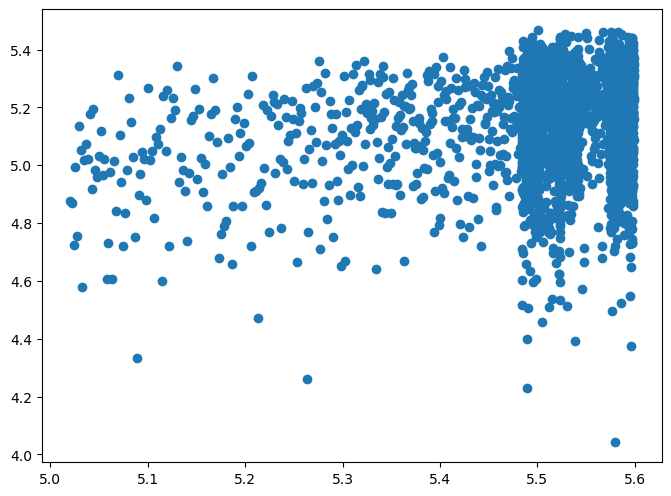

In [374]:
plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(testY, prediction.reshape(prediction.size(0)))
#plt.plot(prediction.reshape(prediction.size(0)))


In [372]:
for i in range(1,19):
    fileName = r"dataset/node" + str(i) +  "mobility.csv"
    df = pd.read_csv (fileName)
    dataX = df['X'].to_numpy()
    dataY = df['Y'].to_numpy()
    dataZ = df['Z'].to_numpy()
    dataYaw = df['Yaw'].to_numpy()
    dataPitch = df['Pitch'].to_numpy()
    dataRoll = df['Roll'].to_numpy()
    dataIndex = np.asarray(list(range(30000)))
    
    
    
    

dataset/node1mobility.csv
dataset/node2mobility.csv
dataset/node3mobility.csv
dataset/node4mobility.csv
dataset/node5mobility.csv
dataset/node6mobility.csv
dataset/node7mobility.csv
dataset/node8mobility.csv
dataset/node9mobility.csv
dataset/node10mobility.csv
dataset/node11mobility.csv
dataset/node12mobility.csv
dataset/node13mobility.csv
dataset/node14mobility.csv
dataset/node15mobility.csv
dataset/node16mobility.csv
dataset/node17mobility.csv
dataset/node18mobility.csv
